In [55]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import math
from sklearn.datasets import load_linnerud
from sklearn import linear_model
import copy

warnings.simplefilter('ignore')

In [56]:
TRAIN_PERCENTAGE = 0.8

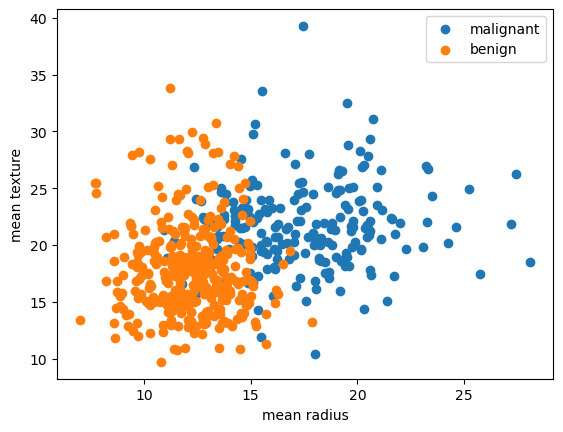

In [57]:
data = load_breast_cancer()
inputs = data['data']
outputs = data['target']
output_names = list(data['target_names'])
feature_names = list(data['feature_names'])

feature1 = [feature[feature_names.index('mean radius')] for feature in inputs]
feature2 = [feature[feature_names.index('mean texture')] for feature in inputs]
inputs = [[feature[feature_names.index('mean radius')], feature[feature_names.index('mean texture')]] for feature in inputs]

labels = set(outputs)
noData = len(inputs)

for categoryLabel in labels:
    x = [feature1[i] for i in range(noData) if outputs[i] == categoryLabel]
    y = [feature2[i] for i in range(noData) if outputs[i] == categoryLabel]
    plt.scatter(x, y, label = output_names[categoryLabel])

plt.xlabel("mean radius")
plt.ylabel("mean texture")
plt.legend()
plt.show()

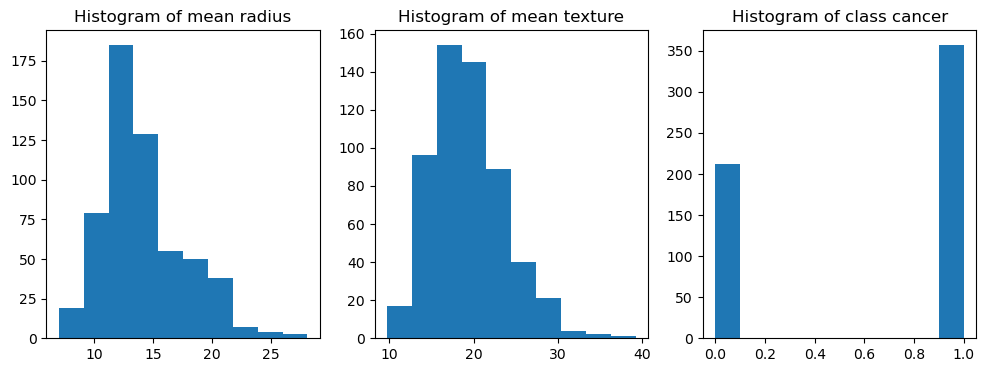

In [58]:
fig, ax = plt.subplots(1, 3, figsize = (4 * 3, 4))
ax[0].hist(feature1, 10)
ax[0].title.set_text('Histogram of mean radius')
ax[1].hist(feature2, 10)
ax[1].title.set_text('Histogram of mean texture')
ax[2].hist(outputs, 10)
ax[2].title.set_text('Histogram of class cancer')

In [59]:
def normalisation(trainData, testData):
    scaler = StandardScaler()
    if not isinstance(trainData[0], list):
        trainData = [[d] for d in trainData]
        testData = [[d] for d in testData]
        
        scaler.fit(trainData)  #  fit only on training data
        normalisedTrainData = scaler.transform(trainData) # apply same transformation to train data
        normalisedTestData = scaler.transform(testData)  # apply same transformation to test data
        
        #decode from list to raw values
        normalisedTrainData = [el[0] for el in normalisedTrainData]
        normalisedTestData = [el[0] for el in normalisedTestData]
    else:
        scaler.fit(trainData)  #  fit only on training data
        normalisedTrainData = scaler.transform(trainData) # apply same transformation to train data
        normalisedTestData = scaler.transform(testData)  # apply same transformation to test data

    return normalisedTrainData, normalisedTestData

In [60]:
def plotClassification(feature1, feature2, outputs, title = None):
    labels = set(outputs)
    noData = len(feature1)

    for categoryLabel in labels:
        x = [feature1[i] for i in range(noData) if outputs[i] == categoryLabel]
        y = [feature2[i] for i in range(noData) if outputs[i] == categoryLabel]
        plt.scatter(x, y, label = output_names[categoryLabel])

    plt.xlabel("mean radius")
    plt.ylabel("mean texture")
    plt.legend()
    plt.show()

In [61]:
np.random.seed(11)

indexes = [i for i in range(len(inputs))]
trainSample = np.random.choice(indexes, int(TRAIN_PERCENTAGE * len(inputs)), replace = False)
testSample = [i for i in indexes if not i in trainSample]

trainInputs = [inputs[i] for i in trainSample]
trainOutputs = [[outputs[i]] for i in trainSample]
testInputs = [inputs[i] for i in testSample]
testOutputs = [[outputs[i]] for i in testSample]

trainInputs, testInputs = normalisation(trainInputs, testInputs)

In [62]:
class Metrics:

    @classmethod
    def BinaryMetrics(cls, predicted, target, trueLabel = 1, falseLabel = 0):
        accuracy = sum([label == targetLabel for label, targetLabel in zip(predicted, target)]) / len(predicted)

        predicted = [x[0] for x in predicted]
        target = [x[0] for x in target]

        TP = sum([plabel == trueLabel for plabel, tlabel in zip(predicted, target) if tlabel == trueLabel])
        TN = sum([plabel == falseLabel for plabel, tlabel in zip(predicted, target) if tlabel == falseLabel])
        FP = sum([plabel == trueLabel for plabel, tlabel in zip(predicted, target) if tlabel == falseLabel])
        FN = sum([plabel == falseLabel for plabel, tlabel in zip(predicted, target) if tlabel == trueLabel])

        precisionPos = TP / (TP + FP) if (TP + FP > 0) else 0
        recallPos = TP / (TP + FN) if (TP + FN > 0) else 0
        precisionNeg = TN / (TN + FN) if (TN + FN > 0) else 0
        recallNeg = TN / (TN + FP) if (TN + FP > 0) else 0

        return {'accuracy': accuracy, 'precision positive': precisionPos, 'recall positive': recallPos, 'precision negative': precisionNeg, 'recall negative': recallNeg}

In [63]:
class LossFunction:

    def __call__(self, predicted, target):
       return (1 / len(predicted)) * sum([(t[0] - p[0]) ** 2 for t, p in zip(target, predicted)])

class ActivationFunction:

    def __call__(self, x):
        return x
    
    def derivative(self, x):
        return 1

class Regularizer:
    
    def __init__(self, lamb):
        self._lamb = lamb

    def __call__(self, weights):
        raise NotImplemented()

In [64]:
class BinaryCrossEntropy(LossFunction):

    def __call__(self, predicted, target):
        #print(list([t[0], p[0]] for t, p in zip(target, predicted) if p[0] == 0 or p[0] == 1))
        return - (1 / len(predicted)) * sum([t * math.log2(min(0.999, p)) + (1 - t) * math.log2(1 - min(0.999, p)) for t, p in zip(target[0], predicted)])
    
    def error(self, predicted, target):
        return (1 / len(predicted)) * sum([p * (1 - p) * (t / max(0.001, p) - (1 - t) / max(0.001, 1 - p)) for t, p in zip(target, predicted)])


class MSE(LossFunction):

    def __call__(self, predicted, target):
       return (1 / 2 * len(predicted)) * sum([(t - p) ** 2 for t, p in zip(target[0], predicted)])
    
    def error(self, predicted, target):
       return (1 / len(predicted)) * sum([(t - p) * p * (1 - p) for t, p in zip(target, predicted)])

In [65]:
class L1Regularizer(Regularizer):

    def __call__(self, weights):
        return self._lamb * sum(weights)

class L2Regularizer(Regularizer):

    def __call__(self, weights):
        return self._lamb / 2 * sum([w ** 2 for w in weights])

In [66]:
class SigmoidFunction(ActivationFunction):

    def __call__(self, x):
        return 1 / (1 + math.exp(-x))
    
    def derivative(self, x):
        value = self(x)
        return value * (1 - value)

In [67]:
class Utils:

    @classmethod
    def BinaryCrossEntropy(cls, predicted, target):
        return 

In [68]:
class RegressorGD:
    
    def __init__(self, params):
        self.__params = params

    @property
    def weights(self):
        return self.__weights

    def __initWeights(self, input_size):
        self.__weights = list(np.random.random(size = input_size + 1))
            
    def __learnBatch(self, inputs, outputs):
        batch_size = len(inputs)

        #print(str(self.__predictRaw(inputs)) + " " + str(outputs[0]))
        error = sum([self.__params['loss'].error(self.__predictRaw([input]), output) for input, output in zip(inputs, outputs)]) / len(inputs) + self.__params['regularizer'](self.__weights)
        inputsAverage = [sum([input[i] for input in inputs]) / len(inputs) for i in range(len(inputs[0]))]

        #print(error)
        for i in range(1, len(self.__weights)):
            self.__weights[i] += (1 / batch_size) * self.__params['lr'] * error * inputsAverage[i - 1]
        self.__weights[0] += self.__params['lr'] * error
    
    def __fitEpoch(self, inputs, outputs):
        noBatches = int(len(inputs) / self.__params['batch_size']) + (1 if (len(inputs) % self.__params['batch_size'] > 0) else 0)

        for i in range(noBatches - 1):
            input = inputs[(i * self.__params['batch_size']):((i + 1) * self.__params['batch_size'])]
            output = outputs[(i * self.__params['batch_size']):((i + 1) * self.__params['batch_size'])]
            self.__learnBatch(input, output)
    
    def __loss(self, inputs, outputs):
        o = self.__predictRaw(inputs)
        return (1 / len(inputs)) * sum([self.__params['loss']([o[j]], [outputs[j]]) for j in range(len(inputs))]) + self.__params['regularizer'](self.__weights)

    def __fitCV(self, inputs, outputs):
        self.__initWeights(len(inputs[0]))

        stats = {'accuracy': [], 'precision': [], 'recall': [], 'loss': [], 'valAccuracy': []}
        for _ in range(self.__params['epochs']):
            self.__fitEpoch(inputs, outputs)
            predicted = self.predict(inputs)
            valPredicted = self.predict(self.__valInputs)

            stat = Metrics.BinaryMetrics(predicted, outputs)

            stats['valAccuracy'].append(Metrics.BinaryMetrics(valPredicted, self.__valOuputs)['accuracy'])
            stats['accuracy'].append(stat['accuracy']), stats['precision'].append('precision positive'), stats['recall'].append('recall positive')
            stats['loss'].append(self.__loss(inputs, outputs))
            
        return stats 
    
    def fit(self, inputs, outputs):
        dim = int(len(inputs) / self.__params['cv_batches'])
        inputBatches = [inputs[(i * dim):((i + 1) * dim)] for i in range(self.__params['cv_batches'])]
        outputBatches = [outputs[(i * dim):((i + 1) * dim)] for i in range(self.__params['cv_batches'])]

        bestWeights = []
        bestError = 0
        bestStats = []

        for i in range(self.__params['cv_batches']):
            trainInputs = []
            trainOutputs = []

            for j in range(self.__params['cv_batches']):
                if i == j:
                    self.__valInputs = inputBatches[i]
                    self.__valOuputs = outputBatches[i]
                else:
                    trainInputs.extend(inputBatches[i])
                    trainOutputs.extend(outputBatches[i])
            
            stats = self.__fitCV(trainInputs, trainOutputs)
            preds = self.predict(self.__valInputs)
            accuracy = Metrics.BinaryMetrics(preds, self.__valOuputs)['accuracy']
            if accuracy > bestError:
                bestError = accuracy 
                bestWeights = copy.deepcopy(self.__weights)
                bestStats = stats

        self.__weights = bestWeights
        return bestStats

    def __predictRaw(self, inputs):
        return [self.__params['activation'](np.dot(input, self.__weights[1:]) + self.__weights[0]) for input in inputs]
    
    def predict(self, inputs):
        return [[1] if x > self.__params['thr'] else [0] for x in self.__predictRaw(inputs)]


In [69]:
params = {'lr': 0.003, 'thr': 0.5, 'epochs': 128, 'loss': MSE(), 'activation': SigmoidFunction(), 'batch_size': 32, 'cv_batches': 2, 'regularizer': L1Regularizer(lamb = 0.01), 'stepsToStop': 5}

In [70]:
regressor = RegressorGD(params = params)
stats = regressor.fit(trainInputs, trainOutputs)

0.40969162995594716


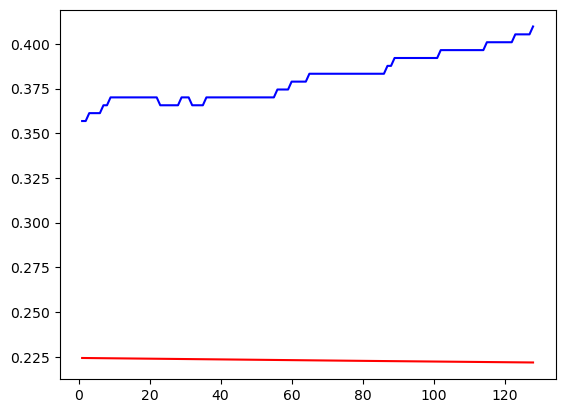

In [71]:
print(stats['accuracy'][-1])
epochs = list(range(1, params['epochs'] + 1))
plt.plot(epochs, stats['loss'], '-r')
plt.plot(epochs, stats['accuracy'], '-b')

plt.show()

In [72]:
predicts = regressor.predict(testInputs)
stats = Metrics.BinaryMetrics(predicts, testOutputs)
print(stats['accuracy'])

0.3684210526315789


In [73]:
regressor = linear_model.SGDClassifier()
regressor.fit(trainInputs, trainOutputs)
predicts = [[p] for p in regressor.predict(testInputs)]

stats = Metrics.BinaryMetrics(predicts, testOutputs)
print(stats['accuracy'])

0.9122807017543859
